In [1]:
## zone imbalance change -- atr saare changes
## imbalance volume condition function verify

###########----------------------------------



In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import plotly.graph_objs as go
import pandas as pd
import pyfolio
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


def resample_to_constant_volume(df, volume_per_candle, convertTime= False):
    # sort by time
    #df = df.sort_values(by='time')
    # create cumulative volume column
    df['cumulative_volume'] = df['volume'].cumsum()
    
    #print(len(df))
    # initialize the new dataframe to hold resampled data
    resampled_df = pd.DataFrame(columns=['open', 'high', 'low', 'close','volume',"date"])
    
    start_index = 0
    end_index = 0
    cumulative_volume = 0
    for i in range(len(df)):
        cumulative_volume += df.iloc[i]['volume']
        end_index = i
        if cumulative_volume >= volume_per_candle : # make function dynamic in next round
            candle_df = df.iloc[start_index:end_index+1]
            open_price = candle_df.iloc[0]['open']
            high_price = candle_df['high'].max()
            low_price = candle_df['low'].min()
            close_price = candle_df.iloc[-1]['close']
            date_end = df.iloc[start_index]["date"]
            #x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
            ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
            #date_end = x.strftime(f"%Y-%m-%d %H:{5*int(x.minute/5)}:%S")
            if convertTime:
                mask = df.iloc[end_index]["date"].split("+")[0]
                x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
                ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
                temp = ("0"+str(5*int(x.minute/5)))
                date_end = x.strftime(f"%Y-%m-%d %H:{temp[-2:]}:%S")
            """resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 
                                                'close': close_price, 'volume': cumulative_volume,
                                                 "date_end": date_end}, 
                                                 ignore_index=True)"""
            for i in range(int(1)):
                resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 
                                                    'close': close_price, 'volume': cumulative_volume,
                                                     "date": date_end}, 
                                                     ignore_index=True)
            cumulative_volume = 0
            start_index = end_index + 1
    
    if start_index < len(df):
        candle_df = df.iloc[start_index:len(df)]
        open_price = candle_df.iloc[0]['open']
        high_price = candle_df['high'].max()
        low_price = candle_df['low'].min()
        close_price = candle_df.iloc[-1]['close']
        volume = sum(candle_df["volume"])
        date_end = df.iloc[start_index]["date"]
        #x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
        ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
        #date_end = x.strftime(f"%Y-%m-%d %H:{5*int(x.minute/5)}:%S")
        if convertTime:
            mask = df.iloc[end_index]["date"].split("+")[0]
            x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
            ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
            temp = ("0"+str(5*int(x.minute/5)))
            date_end = x.strftime(f"%Y-%m-%d %H:{temp[-2:]}:%S")
        resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 'close': close_price, 'volume': volume,"date": str(date_end)}, ignore_index=True)

    return resampled_df
from datetime import timedelta
"""def is_body_size_greater_than_nx_average(dataframe, index,atr_multiple,look_back):
    body_sizes = (dataframe['close'] - dataframe['open']).loc[index - look_back:index].abs()
    #print(body_sizes,"efb")
    average_body_size = body_sizes.mean()
    #print(average_body_size)
    current_body_size = abs(dataframe['close'].loc[index] - dataframe['open'].loc[index])
    return current_body_size > atr_multiple * average_body_size
"""
def is_body_size_greater_than_nx_average(df, index,atr_multiple,look_back):
    body_sizes = (df['close'] - df['open']).loc[index - look_back:index-1].abs()
    average_body_size = body_sizes.mean()
    current_body_size = abs(df['close'].loc[index] - df['open'].loc[index])
    return current_body_size > atr_multiple * average_body_size


# def imbalance_from_volume(df, dateTime_index_to_check, context = {}):
    
#     ind = df[df["date"] == dateTime_index_to_check].index[0]
   
    
# #     x =  pd.to_datetime(datetime.strptime(dateTime_index_to_check, '%Y-%m-%d %H:%M:%S')+timedelta(minutes=1))
# #     endTime = x.strftime(f"%Y-%m-%d %H:%M:%S")

# #     end_index = (df[df["date"] == endTime].index)
# #     if len(end_index):
# #         end_index=end_index[0] ## corner case 15:30
# #     else:
# #         return False
    
#     volume_per_candle = df["volume"].rolling(window=200).mean().rolling(window=30).quantile(0.7).loc[ind]
#     if context:
#         vol_resampled_data1 = resample_to_constant_volume(context["resampled_candles"], volume_per_candle ,convertTime = True)
#         context["resampled_candles"] = vol_resampled_data1
   
    
# #     index_in_vol = vol_resampled_data1.index[-1]#vol_resampled_data1[vol_resampled_data1["date_end"] == dateTime_index_to_check].index[0]
#     #print(index_in_vol,"jk")
#     #print((vol_resampled_data1['volume'][index_in_vol]),volume_per_candle)
#     if(((df['volume'][ind])/volume_per_candle) > 1.3): 
#         return True
#     else :
#         return False


    
def imbalance_zone(df,dateTime_index_to_check,look_back=30):   #return imbalance zone ( price levels)
    
    index = df[df["date"] == dateTime_index_to_check].index[0]
    imbalance_candle = index 
    verify_candle  = index + 1
    
    if is_body_size_greater_than_nx_average(df,index,3,look_back):
        upper = min(min(df["low"].loc[imbalance_candle-look_back:index-1]), df["open"].loc[imbalance_candle])
        lower = max(df["high"].loc[verify_candle],df["close"].loc[imbalance_candle])

        if (upper-lower) >= 0 :
            return [ lower , upper ]  ## test in future the difference of lines more than some % of body

        else :
            return [0,0]
    return [0,0]

def filter_candles_at_index(df, index, body_threshold = 10, untouched_threshold = 20):
    # Calculate the body of the specified candle
    #index = df[df["date"] == dateTime_index_to_check].index[0]
#     print(index)
    df['body'] = df['close'] - df['open']
    body_threshold = (body_threshold+1)*df["body"].mean()
#     print(df["body"])
    body = df.loc[index]['body']
#     print(df)
    # Select only the specified candle if the body is high
    if abs(body) >= body_threshold:
        # Find the percentage of the price range covered by the body that has not been touched by the previous 10 candles
        df['body_min'] = df[['open', 'close']].min(axis=1)
        df['body_max'] = df[['open', 'close']].max(axis=1)
        df['prev_min'] = df['body_min'].shift(1).rolling(window=10).min()
        df['prev_max'] = df['body_max'].shift(1).rolling(window=10).max()
        df['price_range_untouched_min'] = df['body_min'].where(df['body_min'] > df['prev_max'], 0)
        df['price_range_untouched_max'] = df['body_max'].where(df['body_max'] < df['prev_min'], 0)
        df['price_range_untouched'] = df[['price_range_untouched_min', 'price_range_untouched_max']].max(axis=1) - df[['price_range_untouched_min', 'price_range_untouched_max']].min(axis=1)
        df['untouched_percentage'] = df['price_range_untouched'].abs() / df['body'].abs()
        # Select only the specified candle if the percentage is large
        if df.at[index, 'untouched_percentage'] >= untouched_threshold:
            return True
        else:
            return False
    else:
        return False
    
def volCheck(df,dateTime_index_to_check):
    ind = df[df["date"] == dateTime_index_to_check].index[0]
    x =  pd.to_datetime(datetime.strptime(dateTime_index_to_check, '%Y-%m-%d %H:%M:%S')+timedelta(minutes=5))
    #temp = ("0"+str(5*int((x.minute+5)/5)))
    endTime = x.strftime(f"%Y-%m-%d %H:%M:%S")
    # ind2 = df[df["date"] == endTime].index[0]
    # df = df[:ind+1]
    #print(endTime)
    end_index = (df[df["date"] == endTime].index)
    if len(end_index):
        end_index=end_index[0] ## corner case 15:30
    else:
        return False
    
    #print(data["volume"].rolling(window=80000).mean()[ind])
    #vol_resampled_data = resample_to_constant_volume(df[ind-2000:end_index],df["volume"].rolling(window=80000).mean()[ind]*1.7)
    
    volume_per_candle = df["volume"].rolling(window=8000).quantile(0.95).loc[ind]*2.5
    vol_resampled_data1 = resample_to_constant_volume(df.loc[ind-2000:end_index], volume_per_candle ,convertTime = True)
    index = vol_resampled_data1.index[-1]
    return filter_candles_at_index(vol_resampled_data1,index)

    

from collections import defaultdict

def to_intervals(data,n):   # to convert it n minute candle 
    # Read in the data from the text file
    data
    data = data.reset_index()
    data = np.array(data)
    """data = []
    name = "data_2017.txt" #input()
    with open(name, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            # Ignore the first column (stock name)
            data.append(row[1:])"""

    # Convert the data to n-minute intervals
    interval_data =  defaultdict(list)
    for row in data:
        date = row[1].split()[0]
        time = row[1].split()[1].split("+")[0][:-3]
        if time == "09:08:00":
            continue

        open_price = float(row[2])
        high_price = float(row[3])
        low_price = float(row[4])
        close_price = float(row[5])
        volume = float(row[6])
        # Extract the interval from the time and use it as the key in the dictionary
        interval = int(time[-2:]) // n
        interval = f"{time[:2]}:{interval * n:02d}"
        interval = str(date) +" " + interval + ":00"
        interval_data[interval].append((date, time, open_price, high_price, low_price, close_price, volume))

    # Calculate the final open, high, low, and close prices for each interval
    final_prices = {}
    for interval, prices in interval_data.items():
        # Unpack the tuples into separate lists for each price type
        dates, times, opens, highs, lows, closes, volume = zip(*prices)
        # The final open price is the same as the first open price in the interval
        final_open = opens[0]

        # The final high price is the highest of all the high prices in the interval
        final_high = max(highs)
        # The final low price is the lowest of all the low prices in the interval
        final_low = min(lows)
        # The final close price is the same as the last close price in the interval
        final_close = closes[-1]
        # The final volume will be the sum of all volumes of the candels
        final_volume = sum(volume)
        # Store the final prices in a tuple in the dictionary
        final_prices[interval] = (dates[0], times[0], final_open, final_high, final_low, final_close, final_volume)
    
    ws = []
    # Write the data rows
    for interval, final in final_prices.items():
        date, time, open_price, high_price, low_price, close_price, volume = final
        ws.append([date, time, interval, open_price, high_price, low_price, close_price, volume])
    return pd.DataFrame(ws,columns = ["Date", "Time", "date", "open", "high", "low", "close","volume"])
    

def handle_data(context,data):
    ### check on index n-1::
    ## Fetch n-1 candles volume candles:::
    #data = data.reset_index()
    ## exit prev conditions
    if context["canTrade"] == True:
        pass

    if context["position"]:
        if data["high"].iloc[-1]>=context["priceLevels"][1]:    #5*data["std"].iloc[-1]+context["buy"][0]:#sum(context["profitList"])/2:#4*(context["priceLevels"][1] - context["priceLevels"][0]):
            prof = (data["close"].iloc[-1] - np.array(context["buy"][0]))
            context["profit"] += prof
            if prof<0:
                context["losses"] += 1   
            context["profitList"].append(context["profit"])
            context["position"]  = 0
            context["trades"] += 1
            context["canTrade"] = False
            context["buy"] = []
        elif data["low"].iloc[-1]<=context["buy"][0] - (3.6*data["std"].iloc[-1]):#,3*(context["priceLevels"][1] - context["buy"][0])):# context["buy"][0]*10/1300:#data["close"].iloc[-1]-context["buy"]<=-2*(context["priceLevels"][1] - context["priceLevels"][0]):
            context["losses"] += 1
            context["position"] = 0
            context["profit"] += (data["low"].iloc[-1] - np.array(context["buy"][0]))
            context["profitList"].append(context["profit"])
            context["trades"] += 1
            context["canTrade"] = False
            context["buy"] = []
        if context["position"]==0:
            print("squaredOff",data["date"].iloc[-1])
        return
    p1,p2 = 0,0
    for i in range(1):
        candleToCheck = data["date"].iloc[-3-i]
        candleToCheck2 = data["date"].iloc[-4-i]
        if data['timeDiff'].iloc[-3-i]:
            return
        if not (data["timeDiff"].iloc[-3-i]<data["timeDiff"].rolling(window=10).mean().iloc[-3-i-1]):
            return

        p3,p4 = imbalance_zone(data, candleToCheck2 , 30)
        if p3!=p4:
            return
        p1,p2 = imbalance_zone(data, candleToCheck , 30) ##zone funciton....
        
        if p1==p2:
            return
        if p1<data["high"].iloc[-1]:
            return
    
    context["priceLevels"] = [p1,p2]
   
    context["imbalanceCandles"].append(candleToCheck)
    context["canTrade"] = True
    context["currentTradeCandle"] = candleToCheck
    next_candle_strategy_trade(context , data)

def buy(context,price,date = "notSet"):
    print("buy order",date)
    context["position"] += 1
    context["buy"].append(price)
    context['stoploss'] = -100        #price - (sum(context["priceLevels"])/2 - price)#price - 0.08*price   # to be change 
    context["canTrade"] = False

def next_candle_strategy_trade( context , data):
#     print("buy order",data["date"].iloc[-1])
    buy(context,data["close"].iloc[-1],data["date"].iloc[-1])
    
    
def signalTrade(context,data):
    df_vol = resample_to_constant_volume_flex(data.iloc[-1000:-1])
    
    #print(data["date"].iloc[-1],context["currentTradeCandle"])
    #print(data.index[-1],data[data["date"]==context["currentTradeCandle"]])
    if not stillTradable(data,context["currentTradeCandle"],data["date"].iloc[-1],*context["priceLevels"]):
        context["canTrade"] = False
        return

    if aosum(df_vol)["signal"].iloc[-1] :
        buy(context,data["close"].iloc[-1],data["date"].iloc[-1])

def signalTrade_(context,data):
    ## volume per candle consistent for both and imbalance
    df_vol = resample_to_constant_volume_flex(data.iloc[-2000:-1])
    #print(data["date"].iloc[-1],context["currentTradeCandle"])
    #print(data.index[-1],data[data["date"]==context["currentTradeCandle"]])
    if not stillTradable(data,context["currentTradeCandle"],data["date"].iloc[-1],*context["priceLevels"]):
        context["canTrade"] = False
        return
    else:#if buySignalFinder(df_vol)["buySignal"].iloc[-1] :
        buy(context,data["close"].iloc[-1],data["date"].iloc[-1])
        
def aosum(data):
    
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    data["signals1"] = ((data["ao"].shift(4))> (data["ao"].shift(3))) & ((data["ao"].shift(3))> (data["ao"].shift(2))) & ((data["ao"].shift(2)) < data["ao"].shift(1)) 
#     data["signals2"] = ((-data["ao"].shift(4))< (-data["ao"].shift(3))) & (-(data["ao"].shift(3))< (-data["ao"].shift(2))) & (-(data["ao"].shift(2)) > -data["ao"]) &(data["ao"]>0)
    data["signal"] = data["signals1"] 
    return data

def strategy_trade(context,df,candleToCheck):
    data = df.iloc[-50:]
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    signal = data[(data["ao"].shift(4)< data["ao"].shift(3)) & (data["ao"].shift(3)< data["ao"].shift(2)) & (data["ao"].shift(2) > data["ao"])]
    if len(signal):
        ind = signal.index[-1]
        datetime_ = signal["datetime"].loc[ind]  #latest or not ==== send data only after signal
        # datetime.datetime.strptime(datetime_,"")>candleToCheck:

        #TODO 

        buy(context,data["open"].iloc[-1],datetime)
        
    #data[data["ao"].shift(3)< data["ao"].shift(2) and data["ao"].shift(2)< data["ao"].shift(1) and data["ao"].shift(1) > data["ao"]]

def plot(df3,ds=None):
    
    # Create the candlestick chart
    fact = 1
    candlestick = go.Candlestick(x=df3.index, open=df3['open']*fact, close=df3['close']*fact, high=df3['high']*fact, low=df3['low']*fact)
#     line  = go.bar()
    # Add a line plot with secondary x-axis
    sd = []
    if ds!=None:# len(ds):
        line = go.Scatter(x=ds[ds["tt"]].index, y=ds[ds["tt"]]['close'], name='signal', xaxis='x2')
        sd.append(line)
    #line = go.Bar(x=df3.index, y=(df3['volume']/df3["volume"].mean())*data["close"].mean()/3, name='Volume')
    sd.append(candlestick)
    # Create the figure with both the candlestick and line plots
    fig = go.Figure(data=sd)

    # Update the layout to add a secondary x-axis
#     fig.update_layout(xaxis2=dict(title='signal', overlaying='x', side='top'),yaxis2 = dict(title='volume', overlaying='y', side='top'))
    fig.update_layout(xaxis_rangeslider_visible=False)

    # Show the chart
    fig.show()
    return
def plot_candlestick_with_volume(df3):
    # Create the candlestick chart
    candlestick = go.Candlestick(x=df3.index, open=df3['open'], close=df3['close'], high=df3['high'], low=df3['low'])

    # Create the bar plot for volume data
    volume_bar = go.Bar(x=df3.index, y=df3['volume'], name='Volume')

    # Create the figure with both the candlestick and bar plots
    fig = go.Figure(data=[candlestick, volume_bar])

    # Update the layout to add the volume plot below the candlestick chart
    fig.update_layout(xaxis_rangeslider_visible=False, yaxis2=dict(title='Volume', overlaying='y', side='right', showgrid=False, 
                                                                   showline=False, showticklabels=False))

    # Show the chart
    fig.show()
    return

def resample_to_constant_volume_flex(data):
    def volumeSum_threshold():
        cumsum = 0
        val = yield cumsum
        while True:
            if (cumsum < val[1] ) or ("15:29" in val[2]) and ("09:15" not in val[2]):
                cumsum += val[0]
                if ("15:29" in val[2]):
                    cumsum += val[1]
                val = yield cumsum
            else:
                cumsum = val[0]
                val = yield cumsum
    a = volumeSum_threshold()
    next(a)
    data["volume_per_candle"] = data["volume"].rolling(window=20).mean().rolling(window = 130).quantile(0.95)#.rolling(window=20).mean()
    data["volume_per_candle"].fillna(method="bfill",inplace=True)
    data["cumsum"] = data["volume"].cumsum()

    data["volume_vol"] = [a.send(v) for v in np.array(data[["volume","volume_per_candle","date"]])]
    
    data["thesholdBreak"] = data['volume_vol']>data["volume_per_candle"]
    
    data["stamp"] = data['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp())
    
    data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
    data["end"] = data["stamp"]*data["thesholdBreak"].astype(int)
    
    data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["open_vol"].iloc[0] = data["open"].iloc[0]
    data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
    data["open_vol"].fillna(method="ffill",inplace=True)
    
    
    data["start"] = data["stamp"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["start"].iloc[0] = data["stamp"].iloc[0]
    data["start"] = data['start'].where(data["start"] != 0, np.nan)
    data["start"].fillna(method="ffill",inplace=True)
    
    data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
    data["close_vol"].iloc[-1] = data['close'].iloc[-1]
    data["close_vol"].fillna(method="bfill",inplace=True)
    
    data["end"] = data['end'].where(data["end"] != 0, np.nan)
    data["end"].iloc[-1] = data['end'].iloc[-1]
    data["end"].fillna(method="bfill",inplace=True)
    
    def high_():
        hh = 0
        val = yield hh
        while True:
            if val[0]:
                hh = max(hh,val[1])
                val = yield hh
                hh = 0
            else:
                hh = max(hh,val[1])
                val = yield hh
    h = high_()
    next(h)
    def low_():
        ll = np.inf
        val = yield ll
        while True:
            if val[0]:
                ll = min(ll,val[1])
                val = yield ll
                ll = np.inf
            else:
                ll = min(ll,val[1])
                val = yield ll
    l = low_()
    next(l)
    
    data["high_vol"]=[h.send(v) for v in np.array(data[["thesholdBreak","high"]])]
    data["low_vol"] =[l.send(v) for v in np.array(data[["thesholdBreak","low"]])]
    data["open"] = data["open_vol"]
    data["high"] = data["high_vol"]
    data["low"] = data["low_vol"]
    data["close"] = data["close_vol"]
    data["volume"] = data["volume_vol"]
    data["timeDiff"] = data["end"] - data["start"]
    
    
    return data[["date","open","high","low","close","volume_per_candle","volume","timeDiff","start","end"]][data["thesholdBreak"]]

def buySignalFinder(df):
    df["checkSwing"] =  (df['high'] > df['high'].shift(1)) & (df['high'] > df['high'].shift(-1)) & (df['low'] > df['low'].shift(1)) & (df['low'] > df['low'].shift(-1))
    df["index"] = (df["checkSwing"].astype(int))*(df["high"])
    df["index"] = df['index'].where(df['index'] != 0, np.nan)
    df["index"].fillna(method="ffill",inplace=True)
    df["pivotHi"] = df["index"].fillna(0)
    df["buySignal"] = (df["close"]>df["pivotHi"]) & df["pivotHi"]
    return df[["buySignal","pivotHi"]]


def stillTradable(df,imbalance_candle,current_candle, lower_range,upper_range,stop_loss = 0.00,risk_multi=0.3):
    return True
    imbalance_candle_ind = df[df["date"] == imbalance_candle].index[0]
    current_candle_ind = df[df["date"] == current_candle].index[0]

    between_candels = df.loc[imbalance_candle_ind+1:current_candle_ind]

    highest_price_between = between_candels['high'].max()

    if highest_price_between < lower_range :
        # print('highest_price_between < lower_range')
        current_close =df.loc[current_candle_ind]['close']

        target_price = (upper_range+lower_range)/2
        target_distance = target_price - current_close

        # stop_loss = current_close =df.iloc[current_candle_ind]['close']*.002
        return True
        if target_distance > risk_multi*(stop_loss)*current_close:
            # print("target_distance < risk_multi*stop_loss")
            return True
        else:
            print('target & SL not n times')
            return False
    return False
def stillTradable_forBacktest(df,imbalance_candle,current_candle,lower_range,upper_range,stop_loss = 0.00,risk_multi=2):

    imbalance_candle_ind = df[df["date"] == imbalance_candle].index[0]
    current_candle_ind = df[df["date"] == current_candle].index[0]

    between_candels = df.loc[imbalance_candle_ind+1:current_candle_ind]

    highest_price_between = between_candels['high'].max()

    if highest_price_between < lower_range :
        # print('highest_price_between < lower_range')
        current_close =df.loc[current_candle_ind]['close']

        target_price = (upper_range+lower_range)/2
        target_distance = target_price - current_close

        # stop_loss = current_close =df.iloc[current_candle_ind]['close']*.002

        if target_distance > risk_multi*(stop_loss)*current_close:
            # print("target_distance < risk_multi*stop_loss")
            return True
        else:
            print('target & SL not n times')
            return False
    return False



print("adv")

C:\Anaconda\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


adv


In [2217]:
from datetime import datetime
def ss(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S+05:30").strftime("%Y-%m-%d %H:%M:%S")
def nifty_data(x):
    return datetime.strptime(str(x[1]),"%Y%m%d").strftime("%Y-%m-%d")+" "+x[2]+":00"


# --------------------------------
data = pd.read_csv("AMBUJACEM_minute_data_with_indicators.csv", usecols = ["date","open","high","low","close","volume"]).iloc[150971:554674]

#-------------------------
print("data_read")
data["date"]=list(map(ss,data["date"]))
data = resample_to_constant_volume_flex(data.copy())
data["std"] = data["close"].rolling(window=16).std()


data_read


In [2218]:
#run 
#data = pd.read_csv("data.")
data = data.reset_index()
context = {}
context["profit"] = 0
context["profitList"] = []#.append(context["profit"])
context["losses"] = 0

context["position"]  = 0
context["trades"] = 0
context["buy"] = []
context['stoploss'] = 0# price - 0.02*price   # to be change 
context["priceLevels"] = [0,0]
context["imbalanceCandles"] = []
i = data.index[0]+4#int((249971-1000)/1)#data.index[0]+10000
context['resampled_candles'] = data.loc[i-200:i+1]
context["volumeCandles"] = []
context["canTrade"] = False
context["currentTradeCandle"] = ""
#data_5min = to_intervals(data,1)
end = data.index[-1] - 1
while i<(end):
    x = datetime.strptime(data["date"].loc[i],"%Y-%m-%d %H:%M:%S")
    if (datetime(2020,1,1,x.hour,x.minute,0)<datetime(2020,1,1,9,30)):
        i+=1
        continue
    if not i%10000:
        print(i)
    #print(sum(imbalance_zone(data_5min,x)))
    
    handle_data(context,data.loc[i-3000:i+1])
    i+=1

"""while i<(end):
    x = datetime.strptime(data["date"].loc[i],"%Y-%m-%d %H:%M:%S")
    if (datetime(2020,1,1,x.hour,x.minute,0)<datetime(2020,1,1,9,30)):
        i+=5
        continue
    if not i%1000:
        print(i)
    #print(sum(imbalance_zone(data_5min,x)))
    
    handle_data(context,data.loc[i-700:i+1])
    i+=1"""


buy order 2016-11-07 15:02:00
squaredOff 2016-11-07 15:29:00
buy order 2016-12-01 14:37:00
squaredOff 2016-12-01 14:41:00
buy order 2016-12-07 14:33:00
squaredOff 2016-12-08 09:31:00
buy order 2016-12-21 14:33:00
squaredOff 2016-12-21 15:00:00
buy order 2017-01-04 12:13:00
squaredOff 2017-01-04 12:27:00
buy order 2017-01-20 14:41:00
squaredOff 2017-01-20 15:03:00
10000
buy order 2017-04-07 15:05:00
squaredOff 2017-04-07 15:16:00
buy order 2017-04-12 13:59:00
squaredOff 2017-04-12 15:03:00
buy order 2017-05-04 12:17:00
squaredOff 2017-05-04 13:07:00
buy order 2017-05-08 15:17:00
squaredOff 2017-05-09 09:39:00
buy order 2017-05-29 15:05:00
squaredOff 2017-05-29 15:08:00
buy order 2017-07-04 15:04:00
squaredOff 2017-07-04 15:15:00
buy order 2017-07-20 14:03:00
squaredOff 2017-07-20 14:46:00
20000
buy order 2017-09-13 15:22:00
squaredOff 2017-09-14 09:16:00
buy order 2017-09-22 11:35:00
squaredOff 2017-09-22 11:42:00
buy order 2017-09-29 14:22:00
squaredOff 2017-09-29 15:06:00
buy order 20

'while i<(end):\n    x = datetime.strptime(data["date"].loc[i],"%Y-%m-%d %H:%M:%S")\n    if (datetime(2020,1,1,x.hour,x.minute,0)<datetime(2020,1,1,9,30)):\n        i+=5\n        continue\n    if not i%1000:\n        print(i)\n    #print(sum(imbalance_zone(data_5min,x)))\n    \n    handle_data(context,data.loc[i-700:i+1])\n    i+=1'

In [2219]:
context
pro = context["profitList"][:]
pro.insert(0,0)
pro
profits = np.array(context["profitList"][:]) - np.array(pro[:-1])

In [2220]:
len(context['imbalanceCandles']),len(profits)
sd =[]
for i in context["imbalanceCandles"]:
    sd.append(data[data["date"]==i]["close"].iloc[0])
returns = np.array([profits[i]/sd[i] for i in range(len(sd))])

In [2221]:
shar = pyfolio.timeseries.sharpe_ratio(returns)
shar

0.12258907458575978

In [2222]:
1 - context["losses"]/context["trades"]

0.6907216494845361

In [2223]:
context["trades"]

97

In [2224]:
ind1 = data[data["date"] == context['imbalanceCandles'][0]].index[0]
ind2 = data[data["date"] == context['imbalanceCandles'][-1]].index[0]
data["tt"]=data["date"].apply(lambda x: x in context["imbalanceCandles"])
#data.iloc[-1]
data

index                 date    open    high     low   close  \
0       150991  2016-11-03 13:35:00  239.50  240.75  238.10  240.75   
1       151005  2016-11-03 13:49:00  240.75  241.40  239.50  240.50   
2       151020  2016-11-03 14:04:00  240.45  240.80  239.50  239.90   
3       151028  2016-11-03 14:12:00  239.90  239.90  238.45  238.45   
4       151046  2016-11-03 14:30:00  238.30  239.30  237.50  238.40   
...        ...                  ...     ...     ...     ...     ...   
129050  554667  2021-07-14 15:19:00  373.25  373.40  372.95  373.00   
129051  554668  2021-07-14 15:20:00  373.10  373.30  372.85  373.00   
129052  554669  2021-07-14 15:21:00  373.30  373.65  372.85  372.85   
129053  554671  2021-07-14 15:23:00  372.85  373.25  372.85  372.95   
129054  554673  2021-07-14 15:25:00  373.00  373.35  372.85  373.20   

        volume_per_candle    volume  timeDiff         start           end  \
0             189154.9025  194179.0    1200.0  1.478159e+09  1.478160e+09   
1             189154.9025  195154.0     780.0  1.478160e+09  1.478161e+09   
2             189154.9025  222900.0     840.0  1.478161e+09  1.478162e+09   
3             189154.9025  223806.0     420.0  1.478162e+09  1.478163e+09   
4             189154.9025  189553.0    1020.0  1.478163e+09  1.478164e+09   
...                   ...       ...       ...           ...           ...   
129050         14538.8025   26578.0      60.0  1.626256e+09  1.626256e+09   
129051         14538.8025   17185.0       0.0  1.626256e+09  1.626256e+09   
129052         14538.8025   21523.0       0.0  1.626256e+09  1.626256e+09   
129053         14538.8025   19120.0      60.0  1.626256e+09  1.626256e+09   
129054         14538.8025   18443.0      60.0  1.626256e+09  1.626256e+09   

             std     tt  
0            NaN  False  
1            NaN  False  
2            NaN  False  
3            NaN  False  
4            NaN  False  
...          ...    ...  
129050  0.510055  False  
129051  0.444550  False  
129052  0.398630  False  
129053  0.300260  False  
129054  0.232020  False  

[129055 rows x 13 columns]

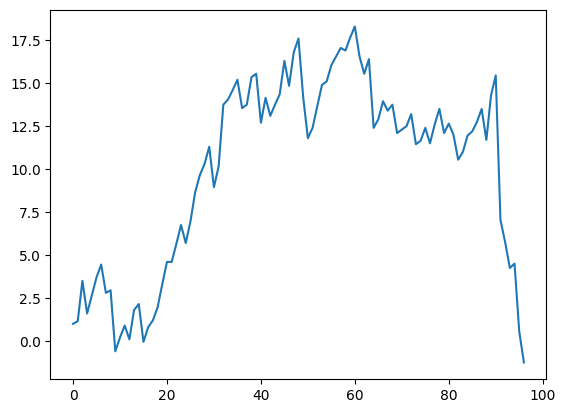

In [2225]:
plt.plot(context["profitList"][:])
#plt.plot([0,len(context["profitList"])],[0,data["close"].loc[ind2]-data["close"].loc[ind1]])
#plt.plot(np.array(data[data["tt"]]["close"].loc[ind1:ind2])-data["close"].loc[ind1])

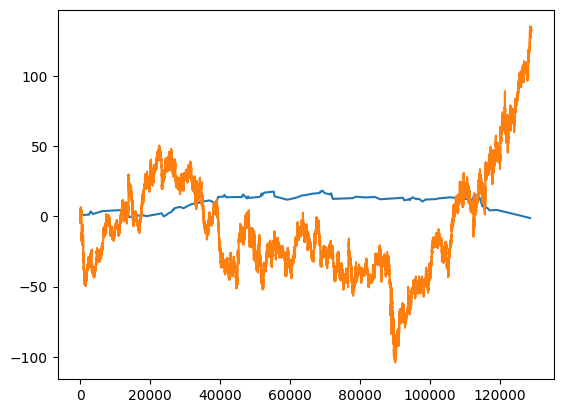

In [2226]:
plt.plot(data[data['tt']].index[:],context["profitList"])
plt.plot(data.index,(data["close"]-data["close"].iloc[0]))

In [1506]:
#data = data.reset_index()
#plot(data[data["tt"]])

dat_ = data.iloc[1000:2000]
plot(dat_)#,dat_[dat_["tt"]])
7

In [1291]:
xs= buySignalFinder(resample_to_constant_volume_flex(data.copy()))

In [1103]:
dat_[dat_["tt"]]

Empty DataFrame
Columns: [index, date, open, high, low, close, volume_per_candle, volume, timeDiff, start, end, std, tt]
Index: []

In [1048]:
data[data["date"] == "2016-11-09 09:15:00"]

index                 date    open   high     low  close  \
998  153356  2016-11-09 09:15:00  417.73  423.7  417.73  420.0   

     volume_per_candle   volume  timeDiff         start           end  \
998          12070.845  81414.0       0.0  1.478663e+09  1.478663e+09   

          std     tt  
998  0.067155  False

In [1049]:
data.loc[151479:151483]

index                 date    open    high     low   close  \
151479  554569  2021-06-24 13:42:00  467.45  467.75  467.40  467.60   
151480  554570  2021-06-24 13:43:00  467.75  467.85  467.10  467.25   
151481  554571  2021-06-24 13:44:00  467.25  467.45  466.95  466.95   
151482  554572  2021-06-24 13:45:00  466.95  467.00  466.80  467.00   
151483  554573  2021-06-24 13:46:00  467.00  467.25  466.65  466.65   

        volume_per_candle   volume  timeDiff         start           end  \
151479            8266.67  18119.0      60.0  1.624522e+09  1.624522e+09   
151480            8266.67  25009.0       0.0  1.624522e+09  1.624522e+09   
151481            8266.67  10149.0       0.0  1.624522e+09  1.624522e+09   
151482            8266.67   8629.0       0.0  1.624522e+09  1.624522e+09   
151483            8266.67  10137.0       0.0  1.624523e+09  1.624523e+09   

             std     tt  
151479  0.023384  False  
151480  0.024250  False  
151481  0.024754  False  
151482  0.027141  False  
151483  0.027633  False

In [1050]:
resample_to_constant_volume_flex(data.copy()).reset_index()[128:131]

index                 date    open    high     low   close  \
128    319  2016-11-02 14:48:00  443.27  443.53  442.67  443.03   
129    323  2016-11-02 14:54:00  443.03  443.13  442.57  442.90   
130    325  2016-11-02 14:57:00  442.97  442.97  441.23  441.53   

     volume_per_candle   volume  timeDiff         start           end  
128         22330.1950  25255.0     360.0  1.478078e+09  1.478078e+09  
129         21423.3525  24415.0     240.0  1.478078e+09  1.478079e+09  
130         20761.2250  22981.0      60.0  1.478079e+09  1.478079e+09

In [1051]:
(xs[xs["buySignal"]==True]).head(40)

buySignal  pivotHi
33        True   446.13
47        True   447.67
49        True   447.67
51        True   447.67
53        True   447.67
55        True   447.67
57        True   447.67
60        True   447.67
62        True   447.67
251       True   440.63
253       True   440.63
255       True   440.63
258       True   440.63
260       True   440.63
263       True   440.63
265       True   440.63
268       True   440.63
271       True   440.63
274       True   440.63
277       True   440.63
280       True   440.63
283       True   440.63
286       True   440.63
295       True   443.23
298       True   443.23
311       True   443.23
315       True   443.23
354       True   440.97
355       True   440.97
356       True   440.97
357       True   440.97
359       True   440.97
361       True   440.97
362       True   440.97
363       True   440.97
387       True   436.50
391       True   436.50
417       True   434.80
421       True   434.80
423       True   434.80

In [324]:
len(xs)

190873

In [ ]:
resample_to_constant_volume_flex

In [956]:
data

date     open     high      low    close  \
150975  2016-10-28 14:19:00  1072.55  1075.65  1072.50  1075.15   
150978  2016-10-28 14:22:00  1075.15  1079.60  1075.15  1076.20   
150983  2016-10-28 14:27:00  1076.20  1077.85  1075.25  1075.55   
150987  2016-10-28 14:31:00  1075.50  1076.00  1074.10  1075.25   
150991  2016-10-28 14:35:00  1075.45  1075.60  1072.00  1072.25   
...                     ...      ...      ...      ...      ...   
554665  2021-06-24 15:18:00  3043.30  3046.00  3042.00  3045.55   
554666  2021-06-24 15:19:00  3044.20  3046.90  3044.10  3044.45   
554668  2021-06-24 15:21:00  3044.35  3047.85  3043.00  3044.55   
554670  2021-06-24 15:23:00  3045.00  3048.00  3044.00  3047.05   
554672  2021-06-24 15:25:00  3047.00  3049.65  3046.05  3048.85   

        volume_per_candle   volume  timeDiff         start           end  \
150975         11909.2550  16153.0     240.0  1.477644e+09  1.477645e+09   
150978         11909.2550  14707.0     120.0  1.477645e+09  1.477645e+09   
150983         11909.2550  15021.0     240.0  1.477645e+09  1.477645e+09   
150987         11909.2550  13549.0     180.0  1.477645e+09  1.477645e+09   
150991         11909.2550  13317.0     180.0  1.477645e+09  1.477646e+09   
...                   ...      ...       ...           ...           ...   
554665          5337.6325  13812.0      60.0  1.624528e+09  1.624528e+09   
554666          5682.9200   6975.0       0.0  1.624528e+09  1.624528e+09   
554668          6140.9000  24005.0      60.0  1.624528e+09  1.624528e+09   
554670          6484.1775   9107.0      60.0  1.624528e+09  1.624528e+09   
554672          6915.8925  11516.0      60.0  1.624528e+09  1.624528e+09   

             std  
150975       NaN  
150978       NaN  
150983       NaN  
150987       NaN  
150991       NaN  
...          ...  
554665  0.790080  
554666  0.749421  
554668  0.705666  
554670  0.648992  
554672  0.692725  

[149873 rows x 11 columns]

In [ ]:
"""data = data.reset_index(drop = True)
data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
#data["open_vol"] = data["open_vol"].where(data["open_vol"] == np.nan, data["open_vol"].iloc[0])
data["open_vol"].iloc[0] = data["open"].iloc[0]
data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
data["open_vol"].fillna(method="ffill",inplace=True)
data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
data["close_vol"].iloc[-1] = data['close'].iloc[-1]
data["close_vol"].fillna(method="bfill",inplace=True)
data["ind"] = data.index*data["thesholdBreak"].astype(int)
data["ind"].iloc[0] = data.index[0]
data["ind"] = data['ind'].where(data["ind"] != 0, np.nan)
data["ind"].iloc[0] = data.index[0]
data["ind"].fillna(method="ffill",inplace=True)
data["ind"] = data["ind"].shift(1)
data["ind"].iloc[0] = data.index[0]
data["ind2"] = data.index*data["thesholdBreak"].astype(int)
data["ind2"].iloc[-1] = data.index[-1]
data["ind2"] = data['ind2'].where(data["ind2"] != 0, np.nan)
data["ind2"].fillna(method="bfill",inplace=True)"""
# data[["ind"]][500:].apply(lambda x: max(data["high"].loc[x.astype(int):(x.index)]))
# data
#data["hh"] = max(data[data["ind"].astype(int):data["ind2"].astype(int)])
def resample_to_constant_volume_flex(data):
    def volumeSum_threshold():
        cumsum = 0
        val = yield cumsum
        while True:
            if cumsum < val[1]:
                cumsum += val[0]
                val = yield cumsum
            else:
                cumsum = val[0]
                val = yield cumsum
    a = volumeSum_threshold()
    next(a)
    data["volume_per_candle"] = data["volume"].rolling(window=360).mean().rolling(window = 300).quantile(0.5)
    data["volume_per_candle"].fillna(method="bfill",inplace=True)
    data["cumsum"] = data["volume"].cumsum()

    data["volume_vol"] = [a.send(v) for v in np.array(data[["volume","volume_per_candle"]])]
    
    data["thesholdBreak"] = data['volume_vol']>data["volume_per_candle"]
    
    data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
    data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["open_vol"].iloc[0] = data["open"].iloc[0]
    data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
    data["open_vol"].fillna(method="ffill",inplace=True)
    data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
    data["close_vol"].iloc[-1] = data['close'].iloc[-1]
    data["close_vol"].fillna(method="bfill",inplace=True)
    
    def high_():
        hh = 0
        val = yield hh
        while True:
            if val[0]:
                hh = max(hh,val[1])
                val = yield hh
                hh = 0
            else:
                hh = max(hh,val[1])
                val = yield hh
    h = high_()
    next(h)
    def low_():
        ll = np.inf
        val = yield ll
        while True:
            if val[0]:
                ll = min(ll,val[1])
                val = yield ll
                ll = np.inf
            else:
                ll = min(ll,val[1])
                val = yield ll
    l = low_()
    next(l)
    
    data["high_vol"]=[h.send(v) for v in np.array(data[["thesholdBreak","high"]])]
    data["low_vol"] =[l.send(v) for v in np.array(data[["thesholdBreak","low"]])]
    data["open"] = data["open_vol"]
    data["high"] = data["high_vol"]
    data["low"] = data["low_vol"]
    data["close"] = data["close_vol"]
    data["volume"] = data["volume_vol"]
    
    
    return data[["date","open","high","low","close","volume_per_candle","volume"]][data["thesholdBreak"]]


In [87]:
def conv(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp()
x = [conv(context["imbalanceCandles"][-1]) , conv(context["imbalanceCandles"][0])]

(array([[1008.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         1009.]]),
 array([0.00000000e+00, 1.62737084e+08, 3.25474169e+08, 4.88211253e+08,
        6.50948338e+08, 8.13685422e+08, 9.76422506e+08, 1.13915959e+09,
        1.30189668e+09, 1.46463376e+09, 1.62737084e+09]),
 <a list of 2 BarContainer objects>)

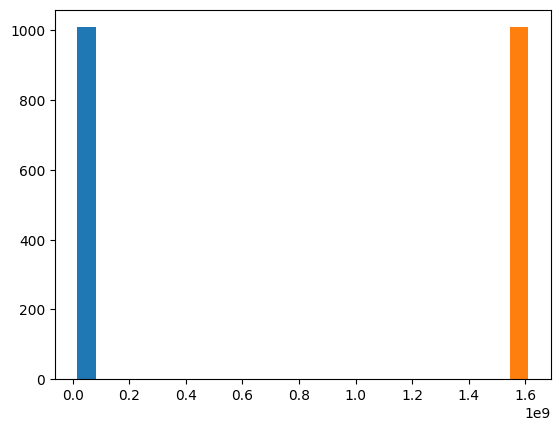

In [90]:
plt.hist(np.histogram(list(map(conv,context['imbalanceCandles'])),bins = np.arange(1514365980.0,1627371480.0,112108)))

x

In [84]:
x/(252*4)

112108.63095238095

In [116]:
bins, data = np.histogram(list(map(conv,context['imbalanceCandles'])))#,bins = np.arange(1514365980.0,1627371480.0,122108))

(array([1., 1., 0., ..., 0., 0., 1.]),
 array([1.51436598e+09, 1.51447809e+09, 1.51459020e+09, ...,
        1.62714663e+09, 1.62725874e+09, 1.62737084e+09]),
 <BarContainer object of 1008 artists>)

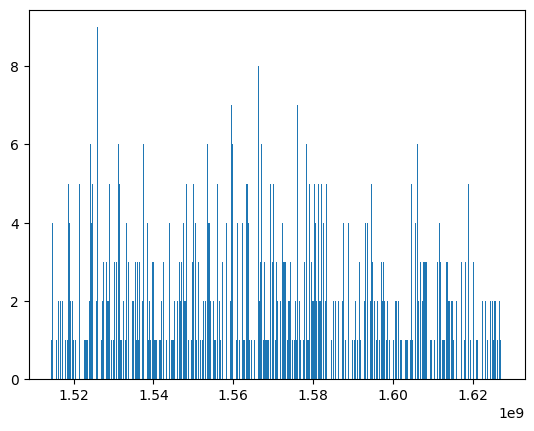

In [117]:
plt.hist(list(map(conv,context['imbalanceCandles'])),bins = np.arange(1514365980.0,1627371480.0,112108))

In [107]:
xx = pd.DataFrame(bins).rolling(window = 2)
xx = xx.mean()
xx - xx.shift(-1)

0
0    NaN
1    0.5
2   -1.5
3    0.0
4    2.0
..   ...
920  0.0
921  0.5
922  0.0
923  0.5
924  NaN

[925 rows x 1 columns]

In [242]:
i = data[data["date"]==context["imbalanceCandles"][7]].index[0]
plot(data.loc[i-5:i+20])

In [198]:
print(data.loc[i])

date      2019-11-01 13:00:00
close                 1559.45
high                  1560.25
low                    1559.0
open                   1559.3
volume                   2165
Name: 404424, dtype: object


In [165]:
import pyperclip
pyperclip.copy(str(context["imbalanceCandles"]))

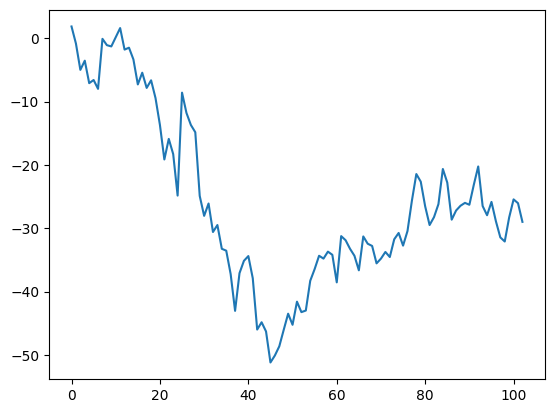

In [243]:
plt.plot(context["profitList"])

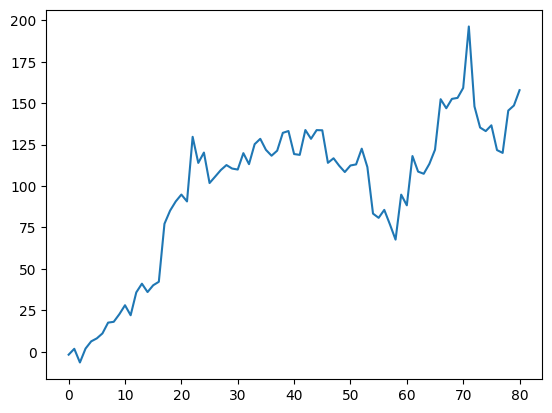

In [222]:
plt.plot(context["profitList"])

In [70]:

# ind = df[df["date"] == dateTime_index_to_check].index[0]

# x =  pd.to_datetime(datetime.strptime(dateTime_index_to_check, '%Y-%m-%d %H:%M:%S')+timedelta(minutes=5))
# endTime = x.strftime(f"%Y-%m-%d %H:%M:%S")
# end_index = (df[df["date"] == endTime].index)
# if len(end_index):
#     end_index=end_index[0] ## corner case 15:30
# else:
#     return False


# volume_per_candle = data["volume"].rolling(window=8000).mean().rolling(window=300).quantile(0.79).loc[ind]*1.3
# vol_resampled_data1 = resample_to_constant_volume(df.loc[ind-2000:end_index], volume_per_candle ,convertTime = True)

# index_in_vol = vol_resampled_data1.index[-1]#vol_resampled_data1[vol_resampled_data1["date_end"] == dateTime_index_to_check].index[0]

# if(((vol_resampled_data1['volume'][index_in_vol])/volume_per_candle) > 2 or (is_body_size_greater_than_nx_average(vol_resampled_data1, index_in_vol ,2,30))):
#     return True
# else :
#     return False

In [69]:
# context = {}
# context["profit"] = 0
# context["profitList"] = []#.append(context["profit"])
# context["losses"] = 0

# context["position"]  = 0
# context["trades"] = 0
# context["buy"] = 0
# context['stoploss'] = 0# price - 0.02*price   # to be change 
# context["priceLevels"] = [0,0]
# context["imbalanceCandles"] = []
# i = data.index[0]+3000
# while i<(len(data)):
#     i+=5
#     da = data["date"].loc[i]
#     (handle_data(context,data.loc[i-700:i+20]))    #print(data.loc[i-10000:i+20],da)
# #     print(imbalance_from_volume(data.loc[i-10000:i+10],da))

In [12]:
# li= []
# #data_5min = data_5min.iloc[-4000:]
# er = data.iloc[5000:]
# for i in er.index:
#     candleToCheck = data["date"][i-10]
#     print(i,candleToCheck)
#     if not imbalance_from_volume(data.loc[i-4000:i], candleToCheck): ##zone funciton....
#         continue
#     li.append(candleToCheck)
#     print(candleToCheck)

155971 2016-11-25 15:10:00
1956 jk
2016-11-25 15:10:00
155972 2016-11-25 15:11:00
1944 jk
2016-11-25 15:11:00
155973 2016-11-25 15:12:00
1935 jk
155974 2016-11-25 15:13:00
1919 jk
2016-11-25 15:13:00
155975 2016-11-25 15:14:00
1887 jk
2016-11-25 15:14:00
155976 2016-11-25 15:15:00
1861 jk
2016-11-25 15:15:00
155977 2016-11-25 15:16:00
1832 jk
2016-11-25 15:16:00
155978 2016-11-25 15:17:00
1830 jk
2016-11-25 15:17:00
155979 2016-11-25 15:18:00
1824 jk
2016-11-25 15:18:00
155980 2016-11-25 15:19:00


KeyboardInterrupt: 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
# li= []
# er = data.iloc[-40000:]
# for i in er.index:
#     candleToCheck = data["date"][i]
#     print("_________")
#     print(data.loc[i-3000:i])
#     print(candleToCheck)
#     print("_________")
#     if not imbalance_from_volume(data.loc[i-3000:i+1], candleToCheck): ##zone funciton....
#         continue
#     li.append(candleToCheck)
#     print(candleToCheck)

In [119]:
profit = 0
buy_price = 0
position = 0
target = 100
sl = -100
trades = 0
losses = 0
pro = []
pnts = []
cells = []
ticker = "^NSEI"
#data = yf.download(ticker,start = "2018-01-01", end = "2021-01-01").reset_index()
print(data.columns)
data= data.reset_index()
#data.columns = ["date","open","high","low","close","as","vol"]
for i in range(0,int(len(data)/1.0)):
    if data["close"][i]>data["open"][i] and not position:
        #buy
        buy_price = data["close"][i]
        position = 1
        pnts.append([i,data["close"][i]])
        pass
    if position:
        if data["close"][i]-buy_price>target:
            profit += target
            position = 0
            #price = position_price
            trades +=1
            cells.append([i,data["close"][i]])
            
        elif data["close"][i] - buy_price<sl:
            profit += sl
            position = 0
            trades +=1
            losses +=1
            cells.append([i,data["close"][i]])
            
    pro.append(profit)
    print(i, profit, trades, losses)

Index(['date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
0 0 0 0
1 0 0 0
2 0 0 0
3 0 0 0
4 0 0 0
5 0 0 0
6 0 0 0
7 0 0 0
8 0 0 0
9 0 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 0 0 0
50 0 0 0
51 0 0 0
52 0 0 0
53 0 0 0
54 0 0 0
55 0 0 0
56 0 0 0
57 0 0 0
58 0 0 0
59 0 0 0
60 0 0 0
61 0 0 0
62 0 0 0
63 0 0 0
64 0 0 0
65 0 0 0
66 0 0 0
67 0 0 0
68 0 0 0
69 0 0 0
70 0 0 0
71 0 0 0
72 0 0 0
73 0 0 0
74 0 0 0
75 0 0 0
76 0 0 0
77 0 0 0
78 0 0 0
79 0 0 0
80 0 0 0
81 0 0 0
82 0 0 0
83 0 0 0
84 0 0 0
85 0 0 0
86 0 0 0
87 0 0 0
88 0 0 0
89 0 0 0
90 0 0 0
91 0 0 0
92 0 0 0
93 0 0 0
94 0 0 0
95 0 0 0
96 0 0 0
97 0 0 0
98 0 0 0
99 0 0 0
100 0 0 0
101 0 0 0
102 0 0 0
103 0 

16916 -200 4 3
16917 -200 4 3
16918 -200 4 3
16919 -200 4 3
16920 -200 4 3
16921 -200 4 3
16922 -200 4 3
16923 -200 4 3
16924 -200 4 3
16925 -200 4 3
16926 -200 4 3
16927 -200 4 3
16928 -200 4 3
16929 -200 4 3
16930 -200 4 3
16931 -200 4 3
16932 -200 4 3
16933 -200 4 3
16934 -200 4 3
16935 -200 4 3
16936 -200 4 3
16937 -200 4 3
16938 -200 4 3
16939 -200 4 3
16940 -200 4 3
16941 -200 4 3
16942 -200 4 3
16943 -200 4 3
16944 -200 4 3
16945 -200 4 3
16946 -200 4 3
16947 -200 4 3
16948 -200 4 3
16949 -200 4 3
16950 -200 4 3
16951 -200 4 3
16952 -200 4 3
16953 -200 4 3
16954 -200 4 3
16955 -200 4 3
16956 -200 4 3
16957 -200 4 3
16958 -200 4 3
16959 -200 4 3
16960 -200 4 3
16961 -200 4 3
16962 -200 4 3
16963 -200 4 3
16964 -200 4 3
16965 -200 4 3
16966 -200 4 3
16967 -200 4 3
16968 -200 4 3
16969 -200 4 3
16970 -200 4 3
16971 -200 4 3
16972 -200 4 3
16973 -200 4 3
16974 -200 4 3
16975 -200 4 3
16976 -200 4 3
16977 -200 4 3
16978 -200 4 3
16979 -200 4 3
16980 -200 4 3
16981 -200 4 3
16982 -200

34907 -100 5 3
34908 -100 5 3
34909 -100 5 3
34910 -100 5 3
34911 -100 5 3
34912 -100 5 3
34913 -100 5 3
34914 -100 5 3
34915 -100 5 3
34916 -100 5 3
34917 -100 5 3
34918 -100 5 3
34919 -100 5 3
34920 -100 5 3
34921 -100 5 3
34922 -100 5 3
34923 -100 5 3
34924 -100 5 3
34925 -100 5 3
34926 -100 5 3
34927 -100 5 3
34928 -100 5 3
34929 -100 5 3
34930 -100 5 3
34931 -100 5 3
34932 -100 5 3
34933 -100 5 3
34934 -100 5 3
34935 -100 5 3
34936 -100 5 3
34937 -100 5 3
34938 -100 5 3
34939 -100 5 3
34940 -100 5 3
34941 -100 5 3
34942 -100 5 3
34943 -100 5 3
34944 -100 5 3
34945 -100 5 3
34946 -100 5 3
34947 -100 5 3
34948 -100 5 3
34949 -100 5 3
34950 -100 5 3
34951 -100 5 3
34952 -100 5 3
34953 -100 5 3
34954 -100 5 3
34955 -100 5 3
34956 -100 5 3
34957 -100 5 3
34958 -100 5 3
34959 -100 5 3
34960 -100 5 3
34961 -100 5 3
34962 -100 5 3
34963 -100 5 3
34964 -100 5 3
34965 -100 5 3
34966 -100 5 3
34967 -100 5 3
34968 -100 5 3
34969 -100 5 3
34970 -100 5 3
34971 -100 5 3
34972 -100 5 3
34973 -100

52958 100 9 4
52959 100 9 4
52960 100 9 4
52961 100 9 4
52962 100 9 4
52963 100 9 4
52964 100 9 4
52965 100 9 4
52966 100 9 4
52967 100 9 4
52968 100 9 4
52969 100 9 4
52970 100 9 4
52971 100 9 4
52972 100 9 4
52973 100 9 4
52974 100 9 4
52975 100 9 4
52976 100 9 4
52977 100 9 4
52978 100 9 4
52979 100 9 4
52980 100 9 4
52981 100 9 4
52982 100 9 4
52983 100 9 4
52984 100 9 4
52985 100 9 4
52986 100 9 4
52987 100 9 4
52988 100 9 4
52989 100 9 4
52990 100 9 4
52991 100 9 4
52992 100 9 4
52993 100 9 4
52994 100 9 4
52995 100 9 4
52996 100 9 4
52997 100 9 4
52998 100 9 4
52999 100 9 4
53000 100 9 4
53001 100 9 4
53002 100 9 4
53003 100 9 4
53004 100 9 4
53005 100 9 4
53006 100 9 4
53007 100 9 4
53008 100 9 4
53009 100 9 4
53010 100 9 4
53011 100 9 4
53012 100 9 4
53013 100 9 4
53014 100 9 4
53015 100 9 4
53016 100 9 4
53017 100 9 4
53018 100 9 4
53019 100 9 4
53020 100 9 4
53021 100 9 4
53022 100 9 4
53023 100 9 4
53024 100 9 4
53025 100 9 4
53026 100 9 4
53027 100 9 4
53028 100 9 4
53029 

71010 200 10 4
71011 200 10 4
71012 200 10 4
71013 200 10 4
71014 200 10 4
71015 200 10 4
71016 200 10 4
71017 200 10 4
71018 200 10 4
71019 200 10 4
71020 200 10 4
71021 200 10 4
71022 200 10 4
71023 200 10 4
71024 200 10 4
71025 200 10 4
71026 200 10 4
71027 200 10 4
71028 200 10 4
71029 200 10 4
71030 200 10 4
71031 200 10 4
71032 200 10 4
71033 200 10 4
71034 200 10 4
71035 200 10 4
71036 200 10 4
71037 200 10 4
71038 200 10 4
71039 200 10 4
71040 200 10 4
71041 200 10 4
71042 200 10 4
71043 200 10 4
71044 200 10 4
71045 200 10 4
71046 200 10 4
71047 200 10 4
71048 200 10 4
71049 200 10 4
71050 200 10 4
71051 200 10 4
71052 200 10 4
71053 200 10 4
71054 200 10 4
71055 200 10 4
71056 200 10 4
71057 200 10 4
71058 200 10 4
71059 200 10 4
71060 200 10 4
71061 200 10 4
71062 200 10 4
71063 200 10 4
71064 200 10 4
71065 200 10 4
71066 200 10 4
71067 200 10 4
71068 200 10 4
71069 200 10 4
71070 200 10 4
71071 200 10 4
71072 200 10 4
71073 200 10 4
71074 200 10 4
71075 200 10 4
71076 200 

88705 200 14 6
88706 200 14 6
88707 200 14 6
88708 200 14 6
88709 200 14 6
88710 200 14 6
88711 200 14 6
88712 200 14 6
88713 200 14 6
88714 200 14 6
88715 200 14 6
88716 200 14 6
88717 200 14 6
88718 200 14 6
88719 200 14 6
88720 200 14 6
88721 200 14 6
88722 200 14 6
88723 200 14 6
88724 200 14 6
88725 200 14 6
88726 200 14 6
88727 200 14 6
88728 200 14 6
88729 200 14 6
88730 200 14 6
88731 200 14 6
88732 200 14 6
88733 200 14 6
88734 200 14 6
88735 200 14 6
88736 200 14 6
88737 200 14 6
88738 200 14 6
88739 200 14 6
88740 200 14 6
88741 200 14 6
88742 200 14 6
88743 200 14 6
88744 200 14 6
88745 200 14 6
88746 200 14 6
88747 200 14 6
88748 200 14 6
88749 200 14 6
88750 200 14 6
88751 200 14 6
88752 200 14 6
88753 200 14 6
88754 200 14 6
88755 200 14 6
88756 200 14 6
88757 200 14 6
88758 200 14 6
88759 200 14 6
88760 200 14 6
88761 200 14 6
88762 200 14 6
88763 200 14 6
88764 200 14 6
88765 200 14 6
88766 200 14 6
88767 200 14 6
88768 200 14 6
88769 200 14 6
88770 200 14 6
88771 200 

106841 200 14 6
106842 200 14 6
106843 200 14 6
106844 200 14 6
106845 200 14 6
106846 200 14 6
106847 200 14 6
106848 200 14 6
106849 200 14 6
106850 200 14 6
106851 200 14 6
106852 200 14 6
106853 200 14 6
106854 200 14 6
106855 200 14 6
106856 200 14 6
106857 200 14 6
106858 200 14 6
106859 200 14 6
106860 200 14 6
106861 200 14 6
106862 200 14 6
106863 200 14 6
106864 200 14 6
106865 200 14 6
106866 200 14 6
106867 200 14 6
106868 200 14 6
106869 200 14 6
106870 200 14 6
106871 200 14 6
106872 200 14 6
106873 200 14 6
106874 200 14 6
106875 100 15 7
106876 100 15 7
106877 100 15 7
106878 100 15 7
106879 100 15 7
106880 100 15 7
106881 100 15 7
106882 100 15 7
106883 100 15 7
106884 100 15 7
106885 100 15 7
106886 100 15 7
106887 100 15 7
106888 100 15 7
106889 100 15 7
106890 100 15 7
106891 100 15 7
106892 100 15 7
106893 100 15 7
106894 100 15 7
106895 100 15 7
106896 100 15 7
106897 100 15 7
106898 100 15 7
106899 100 15 7
106900 100 15 7
106901 100 15 7
106902 100 15 7
106903 1

124906 0 16 8
124907 0 16 8
124908 0 16 8
124909 0 16 8
124910 0 16 8
124911 0 16 8
124912 0 16 8
124913 0 16 8
124914 0 16 8
124915 0 16 8
124916 0 16 8
124917 0 16 8
124918 0 16 8
124919 0 16 8
124920 0 16 8
124921 0 16 8
124922 0 16 8
124923 0 16 8
124924 0 16 8
124925 0 16 8
124926 0 16 8
124927 0 16 8
124928 0 16 8
124929 0 16 8
124930 0 16 8
124931 0 16 8
124932 0 16 8
124933 0 16 8
124934 0 16 8
124935 0 16 8
124936 0 16 8
124937 0 16 8
124938 0 16 8
124939 0 16 8
124940 0 16 8
124941 0 16 8
124942 0 16 8
124943 0 16 8
124944 0 16 8
124945 0 16 8
124946 0 16 8
124947 0 16 8
124948 0 16 8
124949 0 16 8
124950 0 16 8
124951 0 16 8
124952 0 16 8
124953 0 16 8
124954 0 16 8
124955 0 16 8
124956 0 16 8
124957 0 16 8
124958 0 16 8
124959 0 16 8
124960 0 16 8
124961 0 16 8
124962 0 16 8
124963 0 16 8
124964 0 16 8
124965 0 16 8
124966 0 16 8
124967 0 16 8
124968 0 16 8
124969 0 16 8
124970 0 16 8
124971 0 16 8
124972 0 16 8
124973 0 16 8
124974 0 16 8
124975 0 16 8
124976 0 16 8
124977

143049 -200 18 10
143050 -200 18 10
143051 -200 18 10
143052 -200 18 10
143053 -200 18 10
143054 -200 18 10
143055 -200 18 10
143056 -200 18 10
143057 -200 18 10
143058 -200 18 10
143059 -200 18 10
143060 -200 18 10
143061 -200 18 10
143062 -200 18 10
143063 -200 18 10
143064 -200 18 10
143065 -200 18 10
143066 -200 18 10
143067 -200 18 10
143068 -200 18 10
143069 -200 18 10
143070 -200 18 10
143071 -200 18 10
143072 -200 18 10
143073 -200 18 10
143074 -200 18 10
143075 -200 18 10
143076 -200 18 10
143077 -200 18 10
143078 -200 18 10
143079 -200 18 10
143080 -200 18 10
143081 -200 18 10
143082 -200 18 10
143083 -200 18 10
143084 -200 18 10
143085 -200 18 10
143086 -200 18 10
143087 -200 18 10
143088 -200 18 10
143089 -200 18 10
143090 -200 18 10
143091 -200 18 10
143092 -200 18 10
143093 -200 18 10
143094 -200 18 10
143095 -200 18 10
143096 -200 18 10
143097 -200 18 10
143098 -200 18 10
143099 -200 18 10
143100 -200 18 10
143101 -200 18 10
143102 -200 18 10
143103 -200 18 10
143104 -20

161319 0 24 12
161320 0 24 12
161321 0 24 12
161322 0 24 12
161323 0 24 12
161324 0 24 12
161325 0 24 12
161326 0 24 12
161327 0 24 12
161328 0 24 12
161329 0 24 12
161330 0 24 12
161331 0 24 12
161332 0 24 12
161333 0 24 12
161334 0 24 12
161335 0 24 12
161336 0 24 12
161337 0 24 12
161338 0 24 12
161339 0 24 12
161340 0 24 12
161341 0 24 12
161342 0 24 12
161343 0 24 12
161344 0 24 12
161345 0 24 12
161346 0 24 12
161347 0 24 12
161348 0 24 12
161349 0 24 12
161350 0 24 12
161351 0 24 12
161352 0 24 12
161353 0 24 12
161354 0 24 12
161355 0 24 12
161356 0 24 12
161357 0 24 12
161358 0 24 12
161359 0 24 12
161360 0 24 12
161361 0 24 12
161362 0 24 12
161363 0 24 12
161364 0 24 12
161365 0 24 12
161366 0 24 12
161367 0 24 12
161368 0 24 12
161369 0 24 12
161370 0 24 12
161371 0 24 12
161372 0 24 12
161373 0 24 12
161374 0 24 12
161375 0 24 12
161376 0 24 12
161377 0 24 12
161378 0 24 12
161379 0 24 12
161380 0 24 12
161381 0 24 12
161382 0 24 12
161383 0 24 12
161384 0 24 12
161385 0 2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



307167 -300 67 35
307168 -300 67 35
307169 -300 67 35
307170 -300 67 35
307171 -300 67 35
307172 -300 67 35
307173 -300 67 35
307174 -300 67 35
307175 -300 67 35
307176 -300 67 35
307177 -300 67 35
307178 -300 67 35
307179 -300 67 35
307180 -300 67 35
307181 -300 67 35
307182 -300 67 35
307183 -300 67 35
307184 -300 67 35
307185 -300 67 35
307186 -300 67 35
307187 -300 67 35
307188 -300 67 35
307189 -300 67 35
307190 -300 67 35
307191 -300 67 35
307192 -300 67 35
307193 -300 67 35
307194 -300 67 35
307195 -300 67 35
307196 -300 67 35
307197 -300 67 35
307198 -300 67 35
307199 -300 67 35
307200 -300 67 35
307201 -300 67 35
307202 -300 67 35
307203 -300 67 35
307204 -300 67 35
307205 -300 67 35
307206 -300 67 35
307207 -300 67 35
307208 -300 67 35
307209 -300 67 35
307210 -300 67 35
307211 -300 67 35
307212 -300 67 35
307213 -300 67 35
307214 -300 67 35
307215 -300 67 35
307216 -300 67 35
307217 -300 67 35
307218 -300 67 35
307219 -300 67 35
307220 -300 67 35
307221 -300 67 35
307222 -30

325816 -200 68 35
325817 -200 68 35
325818 -200 68 35
325819 -200 68 35
325820 -200 68 35
325821 -200 68 35
325822 -200 68 35
325823 -200 68 35
325824 -200 68 35
325825 -200 68 35
325826 -200 68 35
325827 -200 68 35
325828 -200 68 35
325829 -200 68 35
325830 -200 68 35
325831 -200 68 35
325832 -200 68 35
325833 -200 68 35
325834 -200 68 35
325835 -200 68 35
325836 -200 68 35
325837 -200 68 35
325838 -200 68 35
325839 -200 68 35
325840 -200 68 35
325841 -200 68 35
325842 -200 68 35
325843 -200 68 35
325844 -200 68 35
325845 -200 68 35
325846 -200 68 35
325847 -200 68 35
325848 -200 68 35
325849 -200 68 35
325850 -200 68 35
325851 -200 68 35
325852 -200 68 35
325853 -200 68 35
325854 -200 68 35
325855 -200 68 35
325856 -200 68 35
325857 -200 68 35
325858 -200 68 35
325859 -200 68 35
325860 -200 68 35
325861 -200 68 35
325862 -200 68 35
325863 -200 68 35
325864 -200 68 35
325865 -200 68 35
325866 -200 68 35
325867 -200 68 35
325868 -200 68 35
325869 -200 68 35
325870 -200 68 35
325871 -20

344848 100 71 35
344849 100 71 35
344850 100 71 35
344851 100 71 35
344852 100 71 35
344853 100 71 35
344854 100 71 35
344855 100 71 35
344856 100 71 35
344857 100 71 35
344858 100 71 35
344859 100 71 35
344860 100 71 35
344861 100 71 35
344862 100 71 35
344863 100 71 35
344864 100 71 35
344865 100 71 35
344866 100 71 35
344867 100 71 35
344868 100 71 35
344869 100 71 35
344870 100 71 35
344871 100 71 35
344872 100 71 35
344873 100 71 35
344874 100 71 35
344875 100 71 35
344876 100 71 35
344877 100 71 35
344878 100 71 35
344879 100 71 35
344880 100 71 35
344881 100 71 35
344882 100 71 35
344883 100 71 35
344884 100 71 35
344885 100 71 35
344886 100 71 35
344887 100 71 35
344888 100 71 35
344889 100 71 35
344890 100 71 35
344891 100 71 35
344892 100 71 35
344893 100 71 35
344894 100 71 35
344895 100 71 35
344896 100 71 35
344897 100 71 35
344898 100 71 35
344899 100 71 35
344900 100 71 35
344901 100 71 35
344902 100 71 35
344903 100 71 35
344904 100 71 35
344905 100 71 35
344906 100 71 

363454 200 78 38
363455 200 78 38
363456 200 78 38
363457 200 78 38
363458 200 78 38
363459 200 78 38
363460 200 78 38
363461 200 78 38
363462 200 78 38
363463 200 78 38
363464 200 78 38
363465 200 78 38
363466 200 78 38
363467 200 78 38
363468 200 78 38
363469 200 78 38
363470 200 78 38
363471 200 78 38
363472 200 78 38
363473 200 78 38
363474 200 78 38
363475 200 78 38
363476 200 78 38
363477 200 78 38
363478 200 78 38
363479 200 78 38
363480 200 78 38
363481 200 78 38
363482 200 78 38
363483 200 78 38
363484 200 78 38
363485 200 78 38
363486 200 78 38
363487 200 78 38
363488 200 78 38
363489 200 78 38
363490 200 78 38
363491 200 78 38
363492 200 78 38
363493 200 78 38
363494 200 78 38
363495 200 78 38
363496 200 78 38
363497 200 78 38
363498 200 78 38
363499 200 78 38
363500 200 78 38
363501 200 78 38
363502 200 78 38
363503 200 78 38
363504 200 78 38
363505 200 78 38
363506 200 78 38
363507 200 78 38
363508 200 78 38
363509 200 78 38
363510 200 78 38
363511 200 78 38
363512 200 78 

381523 200 84 41
381524 200 84 41
381525 200 84 41
381526 200 84 41
381527 200 84 41
381528 200 84 41
381529 200 84 41
381530 200 84 41
381531 200 84 41
381532 200 84 41
381533 200 84 41
381534 200 84 41
381535 200 84 41
381536 200 84 41
381537 200 84 41
381538 200 84 41
381539 200 84 41
381540 200 84 41
381541 200 84 41
381542 200 84 41
381543 200 84 41
381544 200 84 41
381545 200 84 41
381546 200 84 41
381547 200 84 41
381548 200 84 41
381549 200 84 41
381550 200 84 41
381551 200 84 41
381552 200 84 41
381553 200 84 41
381554 200 84 41
381555 200 84 41
381556 200 84 41
381557 200 84 41
381558 200 84 41
381559 200 84 41
381560 200 84 41
381561 200 84 41
381562 200 84 41
381563 200 84 41
381564 200 84 41
381565 200 84 41
381566 200 84 41
381567 200 84 41
381568 200 84 41
381569 200 84 41
381570 200 84 41
381571 200 84 41
381572 200 84 41
381573 200 84 41
381574 200 84 41
381575 200 84 41
381576 200 84 41
381577 200 84 41
381578 200 84 41
381579 200 84 41
381580 200 84 41
381581 200 84 

399932 500 87 41
399933 500 87 41
399934 500 87 41
399935 500 87 41
399936 500 87 41
399937 500 87 41
399938 500 87 41
399939 500 87 41
399940 500 87 41
399941 500 87 41
399942 500 87 41
399943 500 87 41
399944 500 87 41
399945 500 87 41
399946 500 87 41
399947 500 87 41
399948 500 87 41
399949 500 87 41
399950 500 87 41
399951 500 87 41
399952 500 87 41
399953 500 87 41
399954 500 87 41
399955 500 87 41
399956 500 87 41
399957 500 87 41
399958 500 87 41
399959 500 87 41
399960 500 87 41
399961 500 87 41
399962 500 87 41
399963 500 87 41
399964 500 87 41
399965 500 87 41
399966 500 87 41
399967 500 87 41
399968 500 87 41
399969 500 87 41
399970 500 87 41
399971 500 87 41
399972 500 87 41
399973 500 87 41
399974 500 87 41
399975 500 87 41
399976 500 87 41
399977 500 87 41
399978 500 87 41
399979 500 87 41
399980 500 87 41
399981 500 87 41
399982 500 87 41
399983 500 87 41
399984 500 87 41
399985 500 87 41
399986 500 87 41
399987 500 87 41
399988 500 87 41
399989 500 87 41
399990 500 87 

In [118]:
bins, data_ = np.histogram(data)#,bins = np.arange(1514365980.0,1627371480.0,122108))

In [119]:
data_

array([1.51436598e+09, 1.52566653e+09, 1.53696708e+09, 1.54826763e+09,
       1.55956818e+09, 1.57086873e+09, 1.58216928e+09, 1.59346983e+09,
       1.60477038e+09, 1.61607093e+09, 1.62737148e+09])

In [153]:
def ancov(x):
    return datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S")
pyperclip.copy(str(list(map(ancov,dd))))

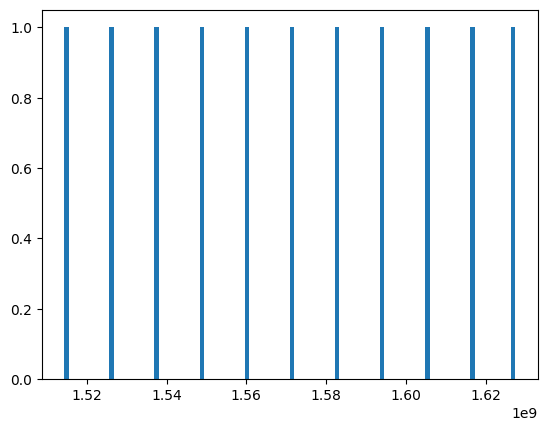

In [129]:
ss= plt.hist(data,bins=100)

In [139]:
np.histogram_bin_edges(dd, bins=40)

array([1.51436598e+09, 1.51719112e+09, 1.52001626e+09, 1.52284139e+09,
       1.52566653e+09, 1.52849167e+09, 1.53131680e+09, 1.53414194e+09,
       1.53696708e+09, 1.53979222e+09, 1.54261736e+09, 1.54544249e+09,
       1.54826763e+09, 1.55109277e+09, 1.55391790e+09, 1.55674304e+09,
       1.55956818e+09, 1.56239332e+09, 1.56521846e+09, 1.56804359e+09,
       1.57086873e+09, 1.57369387e+09, 1.57651900e+09, 1.57934414e+09,
       1.58216928e+09, 1.58499442e+09, 1.58781956e+09, 1.59064469e+09,
       1.59346983e+09, 1.59629497e+09, 1.59912010e+09, 1.60194524e+09,
       1.60477038e+09, 1.60759552e+09, 1.61042066e+09, 1.61324579e+09,
       1.61607093e+09, 1.61889607e+09, 1.62172120e+09, 1.62454634e+09,
       1.62737148e+09])

In [132]:
ss[1]

array([1.51436598e+09, 1.51549604e+09, 1.51662609e+09, 1.51775614e+09,
       1.51888620e+09, 1.52001626e+09, 1.52114631e+09, 1.52227636e+09,
       1.52340642e+09, 1.52453648e+09, 1.52566653e+09, 1.52679658e+09,
       1.52792664e+09, 1.52905670e+09, 1.53018675e+09, 1.53131680e+09,
       1.53244686e+09, 1.53357692e+09, 1.53470697e+09, 1.53583702e+09,
       1.53696708e+09, 1.53809714e+09, 1.53922719e+09, 1.54035724e+09,
       1.54148730e+09, 1.54261736e+09, 1.54374741e+09, 1.54487746e+09,
       1.54600752e+09, 1.54713758e+09, 1.54826763e+09, 1.54939768e+09,
       1.55052774e+09, 1.55165780e+09, 1.55278785e+09, 1.55391790e+09,
       1.55504796e+09, 1.55617802e+09, 1.55730807e+09, 1.55843812e+09,
       1.55956818e+09, 1.56069824e+09, 1.56182829e+09, 1.56295834e+09,
       1.56408840e+09, 1.56521846e+09, 1.56634851e+09, 1.56747856e+09,
       1.56860862e+09, 1.56973868e+09, 1.57086873e+09, 1.57199878e+09,
       1.57312884e+09, 1.57425890e+09, 1.57538895e+09, 1.57651900e+09,
      

In [150]:
dd = np.histogram_bin_edges(sas[sss],bins=80)

In [135]:
ancov(1.51436598e+09)

'2017-12-27 14:43:00'

In [136]:
ancov(1.51450724e+09)

'2017-12-29 05:57:20'

In [140]:
sss,sas = np.histogram(list(map(conv,context['imbalanceCandles'])),bins=800)

In [141]:
len(sss),len(sas)

(800, 801)

In [144]:
sss[sss]

array([1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 3, 0, 2, 1, 2, 1, 1, 1,
       0, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 3, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 3, 3, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3,
       2, 1, 1, 0, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       3, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 1, 1, 1, 1, 3, 1, 3,
       1, 2, 1, 2, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 3, 1,
       1, 1, 1, 1, 1, 3, 3, 2, 1, 2, 3, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1,

In [146]:
sas[sss]

array([1.51450724e+09, 1.51450724e+09, 1.51450724e+09, 1.51478975e+09,
       1.51436598e+09, 1.51464849e+09, 1.51436598e+09, 1.51436598e+09,
       1.51436598e+09, 1.51478975e+09, 1.51436598e+09, 1.51436598e+09,
       1.51436598e+09, 1.51464849e+09, 1.51450724e+09, 1.51436598e+09,
       1.51464849e+09, 1.51493101e+09, 1.51436598e+09, 1.51436598e+09,
       1.51464849e+09, 1.51464849e+09, 1.51436598e+09, 1.51436598e+09,
       1.51450724e+09, 1.51450724e+09, 1.51478975e+09, 1.51436598e+09,
       1.51450724e+09, 1.51478975e+09, 1.51507226e+09, 1.51436598e+09,
       1.51493101e+09, 1.51464849e+09, 1.51464849e+09, 1.51436598e+09,
       1.51436598e+09, 1.51478975e+09, 1.51464849e+09, 1.51450724e+09,
       1.51436598e+09, 1.51436598e+09, 1.51535478e+09, 1.51464849e+09,
       1.51450724e+09, 1.51436598e+09, 1.51436598e+09, 1.51436598e+09,
       1.51436598e+09, 1.51436598e+09, 1.51507226e+09, 1.51493101e+09,
       1.51436598e+09, 1.51436598e+09, 1.51464849e+09, 1.51464849e+09,
      

In [154]:
dates = ['2017-12-27 14:43:00', '2017-12-27 19:37:17', '2017-12-28 00:31:34', '2017-12-28 05:25:51', '2017-12-28 10:20:08', '2017-12-28 15:14:25', '2017-12-28 20:08:42', '2017-12-29 01:02:59', '2017-12-29 05:57:16', '2017-12-29 10:51:33', '2017-12-29 15:45:51', '2017-12-29 20:40:08', '2017-12-30 01:34:25', '2017-12-30 06:28:42', '2017-12-30 11:22:59', '2017-12-30 16:17:16', '2017-12-30 21:11:33', '2017-12-31 02:05:50', '2017-12-31 07:00:07', '2017-12-31 11:54:25', '2017-12-31 16:48:42', '2017-12-31 21:42:59', '2018-01-01 02:37:16', '2018-01-01 07:31:33', '2018-01-01 12:25:50', '2018-01-01 17:20:07', '2018-01-01 22:14:24', '2018-01-02 03:08:41', '2018-01-02 08:02:59', '2018-01-02 12:57:16', '2018-01-02 17:51:33', '2018-01-02 22:45:50', '2018-01-03 03:40:07', '2018-01-03 08:34:24', '2018-01-03 13:28:41', '2018-01-03 18:22:58', '2018-01-03 23:17:15', '2018-01-04 04:11:33', '2018-01-04 09:05:50', '2018-01-04 14:00:07', '2018-01-04 18:54:24', '2018-01-04 23:48:41', '2018-01-05 04:42:58', '2018-01-05 09:37:15', '2018-01-05 14:31:32', '2018-01-05 19:25:49', '2018-01-06 00:20:07', '2018-01-06 05:14:24', '2018-01-06 10:08:41', '2018-01-06 15:02:58', '2018-01-06 19:57:15', '2018-01-07 00:51:32', '2018-01-07 05:45:49', '2018-01-07 10:40:06', '2018-01-07 15:34:23', '2018-01-07 20:28:41', '2018-01-08 01:22:58', '2018-01-08 06:17:15', '2018-01-08 11:11:32', '2018-01-08 16:05:49', '2018-01-08 21:00:06', '2018-01-09 01:54:23', '2018-01-09 06:48:40', '2018-01-09 11:42:57', '2018-01-09 16:37:15', '2018-01-09 21:31:32', '2018-01-10 02:25:49', '2018-01-10 07:20:06', '2018-01-10 12:14:23', '2018-01-10 17:08:40', '2018-01-10 22:02:57', '2018-01-11 02:57:14', '2018-01-11 07:51:31', '2018-01-11 12:45:48', '2018-01-11 17:40:06', '2018-01-11 22:34:23', '2018-01-12 03:28:40', '2018-01-12 08:22:57', '2018-01-12 13:17:14', '2018-01-12 18:11:31', '2018-01-12 23:05:48']


In [237]:
def aosum(data):
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    data["signals"] = (data["ao"].shift(4)< data["ao"].shift(3)) & (data["ao"].shift(3)< data["ao"].shift(2)) & (data["ao"].shift(2) > data["ao"])
    return data

In [238]:
strategy_trade(data)

date    close     high      low     open  volume  \
150971  2016-11-07 13:15:00  1491.10  1493.00  1491.10  1493.00     146   
150972  2016-11-07 13:16:00  1490.65  1492.05  1490.65  1491.95     197   
150973  2016-11-07 13:17:00  1490.65  1492.00  1490.65  1491.55     267   
150974  2016-11-07 13:18:00  1491.40  1493.00  1491.40  1491.60     177   
150975  2016-11-07 13:19:00  1490.65  1492.65  1490.65  1491.55     153   
...                     ...      ...      ...      ...      ...     ...   
554669  2021-07-28 15:24:00  2395.35  2395.65  2394.05  2395.65    1576   
554670  2021-07-28 15:25:00  2391.70  2396.75  2390.15  2395.35    2622   
554671  2021-07-28 15:26:00  2395.00  2395.35  2391.70  2391.70    2092   
554672  2021-07-28 15:27:00  2391.15  2395.00  2391.15  2394.95    1189   
554673  2021-07-28 15:28:00  2386.10  2394.60  2384.80  2391.15    3110   

             mid        ao  signals  
150971  1492.050       NaN    False  
150972  1491.350       NaN    False  
150973  1491.325       NaN    False  
150974  1492.200       NaN    False  
150975  1491.650       NaN    False  
...          ...       ...      ...  
554669  2394.850  1.568529    False  
554670  2393.450  1.467794    False  
554671  2393.525  1.152059    False  
554672  2393.075  0.893382    False  
554673  2389.700 -0.102794    False  

[403703 rows x 9 columns]

In [234]:
data

date    close     high      low     open  volume
150971  2016-11-07 13:15:00  1491.10  1493.00  1491.10  1493.00     146
150972  2016-11-07 13:16:00  1490.65  1492.05  1490.65  1491.95     197
150973  2016-11-07 13:17:00  1490.65  1492.00  1490.65  1491.55     267
150974  2016-11-07 13:18:00  1491.40  1493.00  1491.40  1491.60     177
150975  2016-11-07 13:19:00  1490.65  1492.65  1490.65  1491.55     153
...                     ...      ...      ...      ...      ...     ...
554669  2021-07-28 15:24:00  2395.35  2395.65  2394.05  2395.65    1576
554670  2021-07-28 15:25:00  2391.70  2396.75  2390.15  2395.35    2622
554671  2021-07-28 15:26:00  2395.00  2395.35  2391.70  2391.70    2092
554672  2021-07-28 15:27:00  2391.15  2395.00  2391.15  2394.95    1189
554673  2021-07-28 15:28:00  2386.10  2394.60  2384.80  2391.15    3110

[403703 rows x 6 columns]

In [284]:
data

index                 date     open     high      low    close  \
0       150973  2016-10-28 14:17:00  1072.55  1074.30  1072.50  1073.55   
1       150975  2016-10-28 14:19:00  1073.55  1075.65  1073.55  1075.15   
2       150977  2016-10-28 14:21:00  1075.15  1079.60  1075.15  1077.50   
3       150979  2016-10-28 14:23:00  1077.50  1078.15  1076.05  1076.40   
4       150981  2016-10-28 14:25:00  1076.60  1077.65  1075.25  1076.10   
...        ...                  ...      ...      ...      ...      ...   
126531  554667  2021-06-24 15:20:00  3044.35  3046.65  3043.00  3045.00   
126532  554668  2021-06-24 15:21:00  3046.80  3047.85  3044.55  3044.55   
126533  554669  2021-06-24 15:22:00  3045.00  3047.00  3044.00  3044.95   
126534  554671  2021-06-24 15:24:00  3045.45  3049.20  3044.95  3048.00   
126535  554672  2021-06-24 15:25:00  3048.05  3049.65  3046.05  3048.85   

        volume_per_candle   volume  timeDiff         start           end  \
0             6542.517778   6891.0     120.0  1.477644e+09  1.477644e+09   
1             6542.517778   9262.0      60.0  1.477644e+09  1.477645e+09   
2             6542.517778   9717.0      60.0  1.477645e+09  1.477645e+09   
3             6542.517778   7379.0      60.0  1.477645e+09  1.477645e+09   
4             6542.517778   7111.0      60.0  1.477645e+09  1.477645e+09   
...                   ...      ...       ...           ...           ...   
126531        5150.075000   5933.0       0.0  1.624528e+09  1.624528e+09   
126532        5150.075000  18072.0       0.0  1.624528e+09  1.624528e+09   
126533        5150.075000   5337.0       0.0  1.624528e+09  1.624528e+09   
126534        5150.075000   8517.0      60.0  1.624528e+09  1.624528e+09   
126535        5150.075000   6769.0       0.0  1.624528e+09  1.624528e+09   

              std     tt  
0             NaN  False  
1             NaN  False  
2             NaN  False  
3             NaN  False  
4             NaN  False  
...           ...    ...  
126531  10.221884  False  
126532  10.376402  False  
126533  10.459417  False  
126534  10.497153  False  
126535  10.502803  False  

[126536 rows x 13 columns]

In [340]:
def is_body_size_greater_than_nx_average(df, n1, n2, window):
    df['candle_body'] = abs(df['close'] - df['open'])
    df['avg'] = df['candle_body'].rolling(window=window).mean()

    return ((df['candle_body'] > df['avg']*n1) & (df['candle_body'] < df['avg']*n2) ) & (df['open']>df['close'])

def add_imbalance_zone(dat):
#     dat['upper1'] = np.where(dat['is_imbalance'] , (min(dat['min_last_30'] , dat['open'])) , 0)
#     dat['lower1'] = np.where(dat['is_imbalance'], dat['high'].shift(-1), 0)
    
    dat.loc[dat["is_imbalance"], "upper"] = np.minimum( dat.loc[dat["is_imbalance"], "min_last_30"], dat.loc[dat["is_imbalance"], "open"])  
    dat.loc[dat["is_imbalance"], "lower"] = dat.shift(-1).loc[dat["is_imbalance"], "high"]
    dat["zone"] = (dat["upper"] - dat["lower"])>0
    return dat

In [369]:
#data = data.reset_index()
data['is_imbalance'] = is_body_size_greater_than_nx_average(data, 2,5, 30)
data['min_last_30'] = data['low'].shift(1).rolling(window=30).min()
data["final"] = data["zone"] & (data["timeDiff"]==0) & (data["zone"].shift(1).apply(lambda x: not x))
data = add_imbalance_zone(data)

In [370]:
data[data["final"]].head(20)

level_0   index                 date     open     high      low  \
135       135  151414  2016-11-01 14:23:00  1080.30  1080.35  1077.90   
182       182  151481  2016-11-02 09:15:00  1066.95  1066.95  1057.45   
297       297  151836  2016-11-02 15:10:00  1063.80  1063.80  1061.20   
386       386  152093  2016-11-03 13:12:00  1045.20  1045.70  1042.55   
389       389  152098  2016-11-03 13:17:00  1043.70  1043.75  1041.35   
438       438  152216  2016-11-03 15:15:00  1037.55  1037.60  1035.00   
1062     1062  153752  2016-11-10 09:36:00  1045.60  1046.50  1039.55   
1065     1065  153755  2016-11-10 09:39:00  1038.00  1038.00  1030.10   
1173     1173  154066  2016-11-10 14:50:00  1023.35  1023.50  1020.50   
1276     1276  154301  2016-11-11 12:30:00   973.55   973.85   970.70   
1670     1670  155247  2016-11-17 09:31:00   936.40   936.85   927.25   
1733     1733  155501  2016-11-17 13:45:00   922.95   922.95   920.55   
1738     1738  155506  2016-11-17 13:50:00   920.75   920.75   917.30   
1832     1832  155746  2016-11-18 11:35:00   916.75   916.90   912.55   
1959     1959  155979  2016-11-18 15:28:00   905.20   905.90   902.10   
2657     2657  157676  2016-11-25 12:30:00   946.95   946.95   940.30   
2847     2847  158117  2016-11-28 13:36:00   939.45   939.50   936.00   
3267     3267  159287  2016-12-01 14:21:00   940.20   940.70   938.20   
3316     3316  159356  2016-12-02 09:15:00   935.00   936.45   930.40   
3388     3388  159590  2016-12-02 13:09:00   919.90   919.90   916.45   

        close  volume_per_candle   volume  timeDiff  ...           end  \
135   1078.00          2295.9975   7966.0       0.0  ...  1.477990e+09   
182   1062.90          8457.2975  14635.0       0.0  ...  1.478058e+09   
297   1061.35          4912.2675   6395.0       0.0  ...  1.478080e+09   
386   1042.80          3012.6375   5339.0       0.0  ...  1.478159e+09   
389   1041.45          3291.4325   8029.0       0.0  ...  1.478159e+09   
438   1035.25          6108.9650  10587.0       0.0  ...  1.478166e+09   
1062  1040.65          7467.6650   9671.0       0.0  ...  1.478751e+09   
1065  1031.45          7467.6650  15154.0       0.0  ...  1.478751e+09   
1173  1021.50          3259.8925  14953.0       0.0  ...  1.478770e+09   
1276   970.80          6185.5950  22013.0       0.0  ...  1.478848e+09   
1670   928.35         22107.7025  29301.0       0.0  ...  1.479355e+09   
1733   920.85          2069.4475   7227.0       0.0  ...  1.479370e+09   
1738   917.30          2109.8300  18843.0       0.0  ...  1.479371e+09   
1832   912.55          3194.3675  26604.0       0.0  ...  1.479449e+09   
1959   902.10          7319.9975  25108.0       0.0  ...  1.479463e+09   
2657   944.35          3207.8725  16643.0       0.0  ...  1.480057e+09   
2847   936.60          3379.0825  12591.0       0.0  ...  1.480320e+09   
3267   938.20          3326.3075  16154.0       0.0  ...  1.480582e+09   
3316   932.45          8319.1750  21956.0       0.0  ...  1.480650e+09   
3388   916.45          4387.3450  26009.0       0.0  ...  1.480664e+09   

           std  is_imbalance  min_last_30    upper    lower  zone  \
135   2.115139          True      1078.55  1078.55  1078.00  True   
182   2.544847          True      1072.20  1066.95  1064.80  True   
297   4.611479          True      1062.50  1062.50  1062.15  True   
386   1.886857          True      1044.50  1044.50  1043.85  True   
389   2.277401          True      1042.55  1042.55  1042.20  True   
438   1.965544          True      1035.65  1035.65  1035.30  True   
1062  4.151383          True      1043.25  1043.25  1042.00  True   
1065  5.161749          True      1037.10  1037.10  1032.20  True   
1173  1.792990          True      1023.30  1023.30  1023.00  True   
1276  3.155404          True       973.55   973.55   972.00  True   
1670  4.477737          True       930.10   930.10   929.00  True   
1733  1.756203          True       922.00   922.00   921.75  True   
1738  2.421451      

In [363]:
i = 3267
plot(data[i-7:i+60])

In [364]:
data[i-4:i+30]

level_0   index                 date    open    high     low   close  \
3263     3263  159279  2016-12-01 14:13:00  940.60  941.45  940.15  940.60   
3264     3264  159281  2016-12-01 14:15:00  941.15  941.20  940.30  940.85   
3265     3265  159284  2016-12-01 14:18:00  940.85  941.85  940.50  940.50   
3266     3266  159286  2016-12-01 14:20:00  940.50  940.80  940.10  940.20   
3267     3267  159287  2016-12-01 14:21:00  940.20  940.70  938.20  938.20   
3268     3268  159288  2016-12-01 14:22:00  938.45  939.60  938.20  939.45   
3269     3269  159290  2016-12-01 14:24:00  939.10  939.20  937.75  937.75   
3270     3270  159291  2016-12-01 14:25:00  937.75  938.95  937.75  938.70   
3271     3271  159293  2016-12-01 14:27:00  938.20  939.45  938.20  938.50   
3272     3272  159295  2016-12-01 14:29:00  938.50  938.70  938.15  938.35   
3273     3273  159296  2016-12-01 14:30:00  938.40  938.40  936.50  937.45   
3274     3274  159297  2016-12-01 14:31:00  937.15  937.30  936.00  936.00   
3275     3275  159298  2016-12-01 14:32:00  936.05  937.00  936.00  936.15   
3276     3276  159299  2016-12-01 14:33:00  936.15  937.70  936.15  937.00   
3277     3277  159300  2016-12-01 14:34:00  937.00  938.15  937.00  937.60   
3278     3278  159302  2016-12-01 14:36:00  937.60  938.15  936.50  937.30   
3279     3279  159304  2016-12-01 14:38:00  936.80  937.90  936.50  937.75   
3280     3280  159306  2016-12-01 14:40:00  937.90  937.95  937.00  937.35   
3281     3281  159308  2016-12-01 14:42:00  937.35  937.35  936.25  936.70   
3282     3282  159310  2016-12-01 14:44:00  936.75  936.95  936.25  936.55   
3283     3283  159311  2016-12-01 14:45:00  936.55  939.15  936.55  939.00   
3284     3284  159313  2016-12-01 14:47:00  939.00  939.10  937.95  938.05   
3285     3285  159315  2016-12-01 14:49:00  938.05  938.35  936.80  936.95   
3286     3286  159317  2016-12-01 14:51:00  936.95  937.40  936.55  937.20   
3287     3287  159319  2016-12-01 14:53:00  937.20  937.50  936.50  936.55   
3288     3288  159320  2016-12-01 14:54:00  936.55  937.90  936.55  937.00   
3289     3289  159322  2016-12-01 14:56:00  937.00  938.60  936.45  938.10   
3290     3290  159324  2016-12-01 14:58:00  938.10  939.00  937.20  937.55   
3291     3291  159326  2016-12-01 15:00:00  937.55  938.10  937.25  937.25   
3292     3292  159328  2016-12-01 15:02:00  937.25  938.35  936.85  938.00   
3293     3293  159329  2016-12-01 15:03:00  938.00  938.45  937.00  938.25   
3294     3294  159331  2016-12-01 15:05:00  938.25  938.50  937.10  938.50   
3295     3295  159333  2016-12-01 15:07:00  938.50  939.95  938.00  939.60   
3296     3296  159334  2016-12-01 15:08:00  939.60  940.40  939.35  939.50   

      volume_per_candle   volume  timeDiff  ...           end       std  \
3263          3326.3075   3589.0      60.0  ...  1.480582e+09  1.427100   
3264          3326.3075   3879.0      60.0  ...  1.480582e+09  1.479829   
3265          3326.3075   3739.0     120.0  ...  1.480582e+09  1.541574   
3266          3326.3075   3488.0      60.0  ...  1.480582e+09  1.607788   
3267          3326.3075  16154.0       0.0  ...  1.480582e+09  1.749264   
3268          3326.3075   4896.0       0.0  ...  1.480582e+09  1.823090   
3269          3326.3075  10667.0      60.0  ...  1.480582e+09  1.974820   
3270          3326.3075   4459.0       0.0  ...  1.480582e+09  2.061667   
3271          3389.1700   5849.0      60.0  ...  1.480583e+09  2.131289   
3272          3398.9300   8269.0      60.0  ...  1.480583e+09  2.199756   
3273          3407.5775  16678.0       0.0  ...  1.480583e+09  2.290024   
3274          3420.0450   6124.0       0.0  ...  1.480583e+09  2.415369   
3275          3435.0475   6190.0       0.0  ...  1.480583e+09  2.510975   
3276          3451.3300   3500.0       0.0  ...  1.480583e+09  2.551465   
3277          3545.5000   7487.0       0.0  ...  1.480583e+09  2.578483   
3278          4354.8325   7204.0      60.0  ...  1.480583e+09  2.605818   


In [374]:
import pyperclip
pyperclip.copy(str(list(data[data["final"]]["date"])))

In [322]:
sd = list(data[data["is_imbalance"]].index)
ss = list(data[data['timeDiff']==0].index)
li = []

In [328]:
for ind in li.copy():
    if (ind in ss) or (ind+1 in ss) or (ind-1 in ss):
        continue
    else:
        li.append(ind)

In [329]:
len(ss),len(li),len(sd)

(29700, 1742, 2064)

In [330]:
len(set(li))

871

In [ ]:
mer